In [1]:


%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np
import torch.nn as nn
torch.manual_seed(0)

In [4]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy') 
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


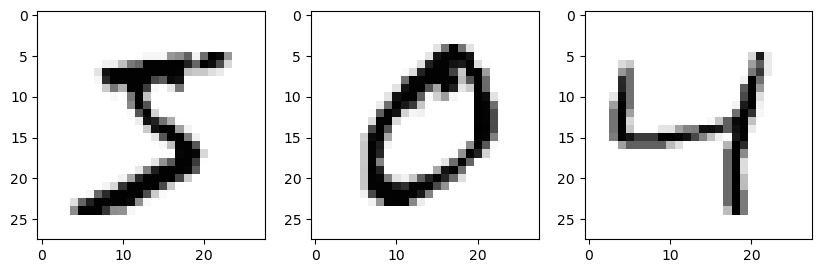

In [5]:


plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [6]:


#reshaping the arrays by taking the product of the last two dimensions of the array and making sure 
#the products are all integers before reshaping the array into a flattened 2d array

mnist_train_features = mnist_train_features.reshape((-1, int(np.prod(mnist_train_features.shape[-2:]))))
mnist_test_features = mnist_test_features.reshape((-1, int(np.prod(mnist_test_features.shape[-2:]))))

print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [7]:
#import the standard scalar from python and set it up
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#rescale the data
mnist_train_features =scaler.fit_transform(mnist_train_features)
mnist_test_features = scaler.fit_transform(mnist_test_features)

In [8]:
#split the features and targets at the row that would be 90% 
splitted_features=np.split(mnist_train_features, [900])
splitted_targets=np.split(mnist_train_targets, [900])

#call the second array of the splitted array to get the 10% for validation 
mnist_validation_features = splitted_features[1]
mnist_validation_targets = splitted_targets[1]

#call the first array of the splitted array to get the 90% for training
mnist_train_features = splitted_features[0]
mnist_train_targets = splitted_targets[0]

In [9]:
class mnistClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim): 
        
        super(mnistClassification, self).__init__()
        
        #first layer with 50 hidden nodes
        self.layer1=torch.nn.Linear(input_dim, 50)
        
        #output layer
        self.layer2=torch.nn.Linear(50, output_dim)
    
    
        
    def forward(self, x):
        
        #relu activation for input and output layers
        x=nn.functional.relu(self.layer1(x))
        x=nn.functional.relu(self.layer2(x))
        out=x
        
        return out

In [10]:

model = mnistClassification(input_dim=784 ,output_dim=10)

# Define the learning rate and epoch 
learning_rate = 0.01
epochs = 500
batchsize = 1

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

if torch.cuda.is_available():
    model.cuda()

model

mnistClassification(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

In [11]:


train_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

In [12]:
import tqdm

mnist_train_features = torch.from_numpy(mnist_train_features).float()
mnist_validation_features = torch.from_numpy(mnist_validation_features).float()
mnist_test_features = torch.from_numpy(mnist_test_features).float()

mnist_train_targets = torch.from_numpy(mnist_train_targets).long()
mnist_validation_targets = torch.from_numpy(mnist_validation_targets).long()
mnist_test_targets = torch.from_numpy(mnist_test_targets).long()



for epoch in tqdm.trange(epochs):
    
    
        #tracking the outputs of the data 
        train_outputs = model(mnist_train_features)
        
    
        #computing the loss with actual values
        loss=loss_func(train_outputs, mnist_train_targets)
        
        #empyting the gradient buffer
        optimizer.zero_grad()
        
        #updating the loss list so that we can plot it
        train_loss_list[epoch]=loss.item()
        
        #compute the changes that need to be made to the weights/biases
        loss.backward()
        
        #updating the weights/biases
        optimizer.step()
        
        
        with torch.no_grad(): 
        
        # tracking the validation data
            validation_outputs = model(mnist_validation_features)
          
        
            #true false classification of if the validation outputs match the actual data we have
            correct = (torch.argmax(validation_outputs, dim=1) == 
                   mnist_validation_targets).type(torch.FloatTensor)
            
            #find the validation by taking the average accuracy 
            validation_accuracy_list[epoch] = correct.mean()
        


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 294.41it/s]


In [13]:


import seaborn as sns

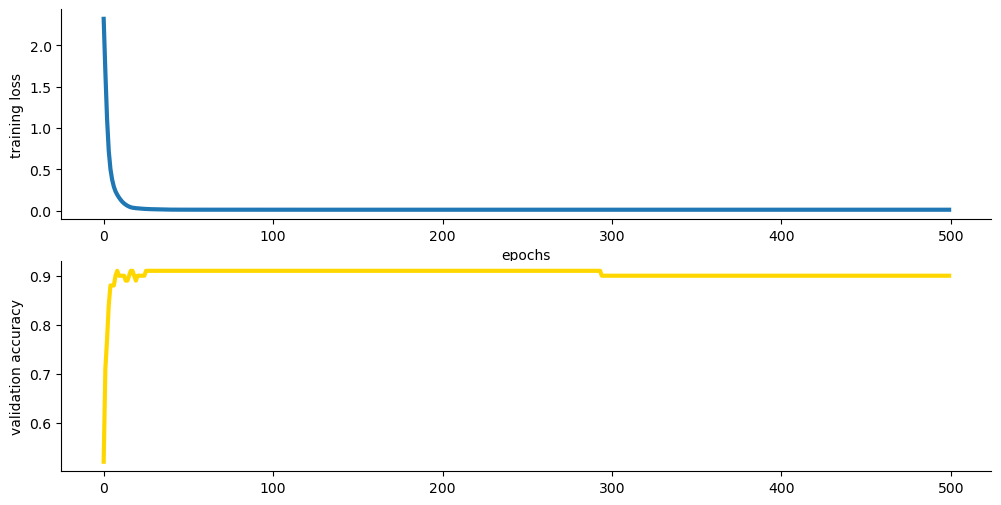

In [14]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [15]:
# Compute the testing accuracy 

with torch.no_grad():
    
    #find the predictions or outputs of the model
    y_pred_test = model(mnist_test_features) 
    
    # true/false measure to find the mean and turn that into a percentage for the accuracy 
    correct = (torch.argmax(y_pred_test, dim=1) == mnist_test_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')

Testing Accuracy: 92.00000166893005%


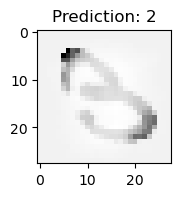

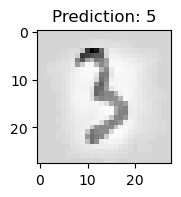

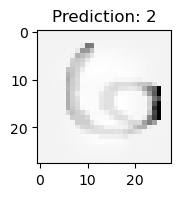

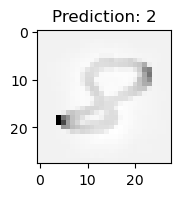

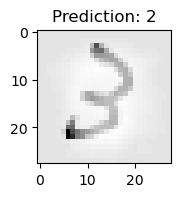

In [16]:


import math
with torch.no_grad():
    
    #find our outputs of the model
    predicted = model(mnist_test_features)
    #convert into integer numbers so we have an actual predicted value
    predicted = torch.argmax(predicted, dim=1).type(torch.int)
    #find the indices of where the predictions don't match up with the targets
    incorrect = np.where(predicted.numpy()!= mnist_test_targets.numpy())[0]
    #take the first five incorrect values
    incorrect_indices = incorrect[:5]

    #calulate the rows needed for the subplot
    num_rows = int(math.ceil(len(incorrect_indices) / 5.0))

    #create a for loop to print each value running through the indices
    for i, incorrect_idx in enumerate(incorrect_indices):
        #the image that was incorrectly predicted
        input_image = mnist_test_features[incorrect_idx]
        #the predicted value according to the model
        predicted_label = predicted[incorrect_idx]
        #reshaping the matrix into a readable graphic
        twod = input_image.reshape(1,28, 28)
        plt.figure(figsize=(10, 10))
        plt.subplot(num_rows, 5, i+1)
        plt.imshow(twod[0], cmap='Greys')
        plt.title(f"Prediction: {predicted_label}")  
        